In [42]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, \
    mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing, svm

In [54]:
from IPython.display import clear_output
%matplotlib inline


def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()


def plot_assignation(data: pd.DataFrame, title: str, xlabel: str,
                     ylabel: str, figsize: tuple[int, int] = (20, 5)) -> None:
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [2]:
df = pd.read_csv(
    os.path.join(
        os.sep,
        os.path.abspath(os.curdir),
        'data',
        'Daily foreign exchange rates AustraliaUS BritishUS CanadianUS DutchUS .csv'),
    index_col=0)
ts = df['X0.90440445'].interpolate('linear').bfill()
ts.index = ts.index - 1

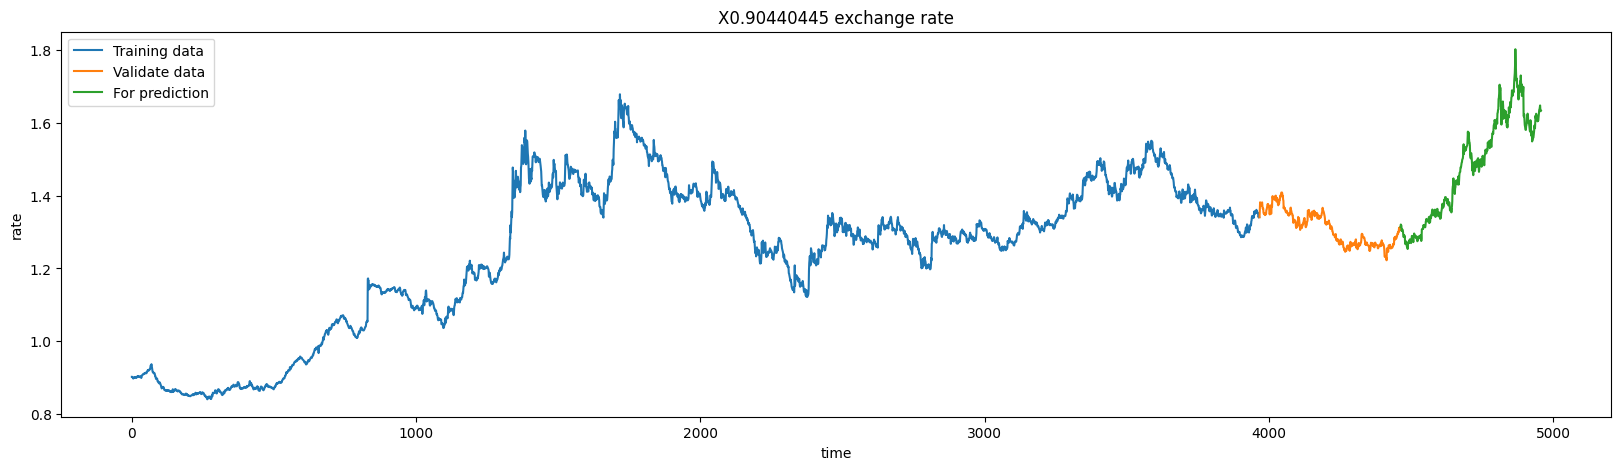

In [3]:

series = ts
ln = len(series)
train_cutoff = int(round(ln * 0.8, 0))
validate_cutoff = int(round(ln * 0.9, 0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_ts = series[series.index <= train_cutoff]
validate_ts = series[(series.index > train_cutoff) &
                     (series.index <= validate_cutoff)]
forecast_ts = series[series.index > validate_cutoff]

# Выводим график данных
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(train_ts.index, train_ts, label='Training data')
plt.plot(validate_ts.index, validate_ts, label='Validate data')
plt.plot(forecast_ts.index, forecast_ts, label='For prediction')
plt.legend()
plt.title('X0.90440445 exchange rate')
plt.ylabel('rate')
plt.xlabel('time')
plt.show()

### ARMA и ARIMA

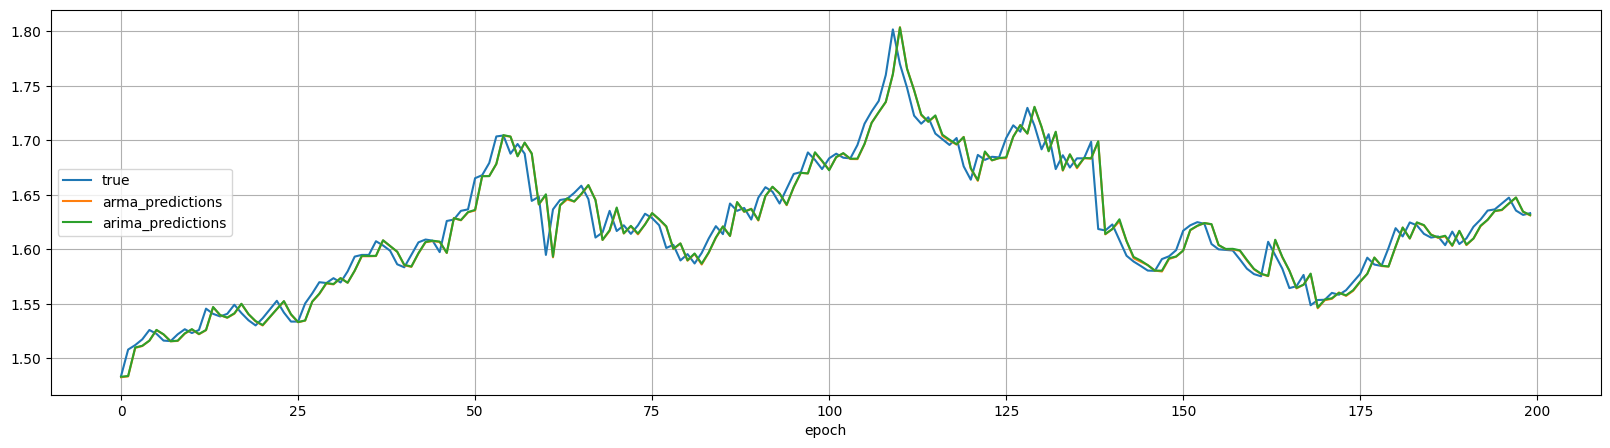

In [18]:
series = ts

size = len(series) - 200
train, test = series[:size], series[size:len(series)]
history = [x for x in train]

# walk-forward validation
val = {'true': [], 'arma_predictions': [], 'arima_predictions': []}
for t in range(size, len(series)):
    arma_model_fit = ARIMA(history, order=(3, 0, 2)).fit()
    val['arma_predictions'].append(arma_model_fit.forecast()[0])

    arima_model_fit = ARIMA(history, order=(3, 1, 2)).fit()
    val['arima_predictions'].append(arima_model_fit.forecast()[0])

    history.append(test[t])
    val['true'].append(test[t])

    live_plot(val, (20, 5))

In [39]:
# По аналогии с AR ARMA и ARIMA в качестве предсказаний также выдают последнее значение ряда

In [120]:
def calculate_smape(actual, predicted):
    return round(
        np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)))), 19)


print('ARMA metrics')
print('RMSE:', np.sqrt(mean_squared_error(val['arma_predictions'], test)))
print('MAPE:', mean_absolute_percentage_error(val['arma_predictions'], test))
print('SMAPE:', calculate_smape(val['arma_predictions'], test))
print('MAE:', mean_absolute_error(val['arma_predictions'], test))
print('R2:', r2_score(val['arma_predictions'], test))

print('\n', 'ARIMA metrics', sep='')
print('RMSE:', np.sqrt(mean_squared_error(val['arima_predictions'], test)))
print('MAPE:', mean_absolute_percentage_error(val['arima_predictions'], test))
print('SMAPE:', calculate_smape(val['arima_predictions'], test))
print('MAE:', mean_absolute_error(val['arima_predictions'], test))
print('R2:', r2_score(val['arima_predictions'], test))

ARMA metrics
RMSE: 0.014694519729188992
MAPE: 0.006382893760030931
SMAPE: 0.0031928363489365282
MAE: 0.010436726961293653
R2: 0.9387687948924122

ARIMA metrics
RMSE: 0.01467811101555899
MAPE: 0.006360842581274737
SMAPE: 0.0031823433000025343
MAE: 0.010405273260639092
R2: 0.9388577244882196


### Разница в предсказаниях между ARMA и ARIMA

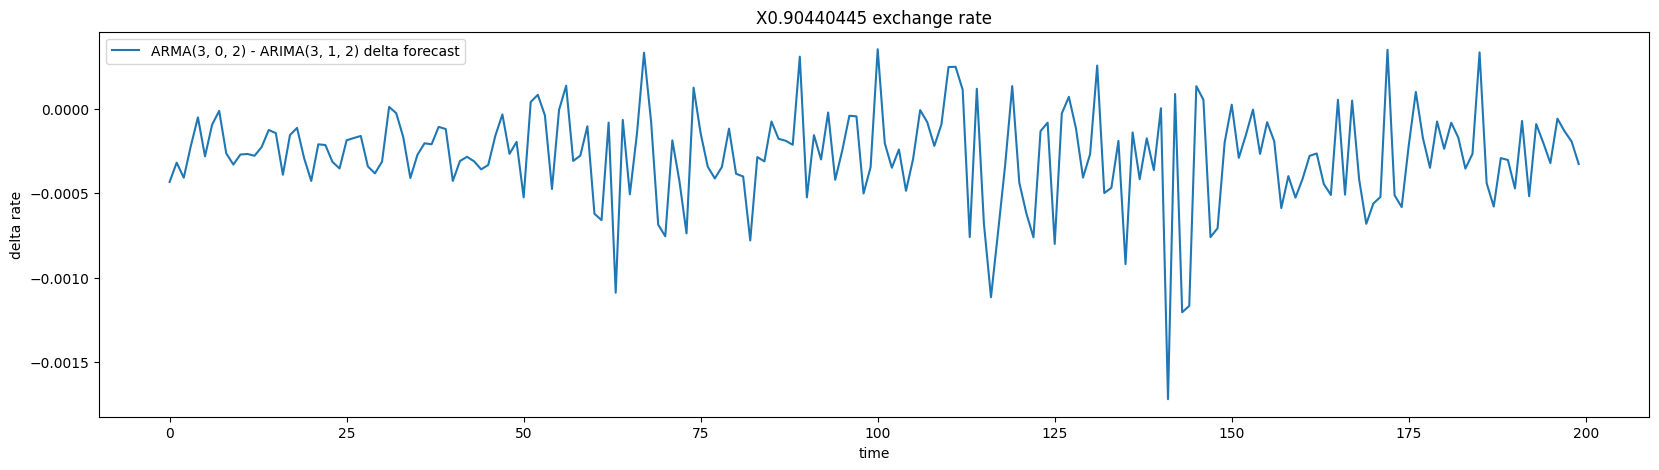

In [31]:
fig = plt.figure(figsize=(20, 5))

delta = np.array(val['arma_predictions']) - val['arima_predictions']

plt.plot(delta, label='ARMA(3, 0, 2) - ARIMA(3, 1, 2) delta forecast')
plt.legend()
plt.title('X0.90440445 exchange rate')
plt.ylabel('delta rate')
plt.xlabel('time')
plt.show()

### Работа с пропусками

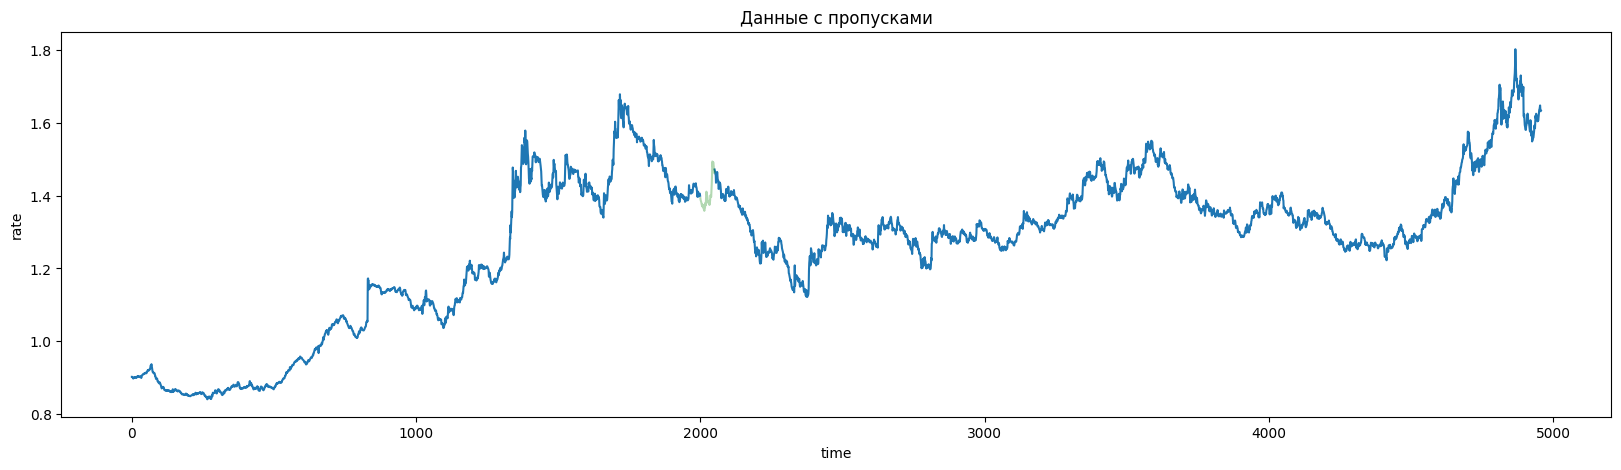

In [74]:
missing_values = ts.copy()
missing_values[2000:2050] = np.nan
plot_assignation(missing_values, 'Данные с пропусками', 'time', 'rate')
plt.plot(ts[2000:2050], color='g', alpha=0.3)
plt.show()

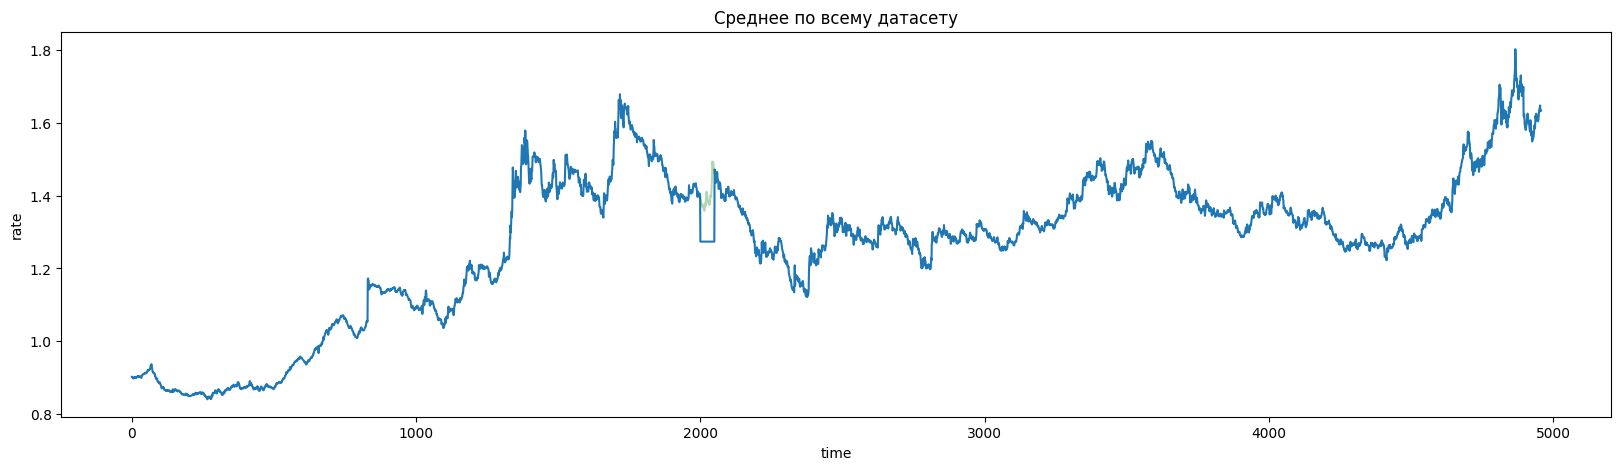

In [78]:
restored = missing_values.copy()
restored[2000:2050] = np.mean(missing_values.dropna())
plot_assignation(restored, 'Среднее по всему датасету', 'time', 'rate')
plt.plot(ts[2000:2050], color='g', alpha=0.3)
plt.show()

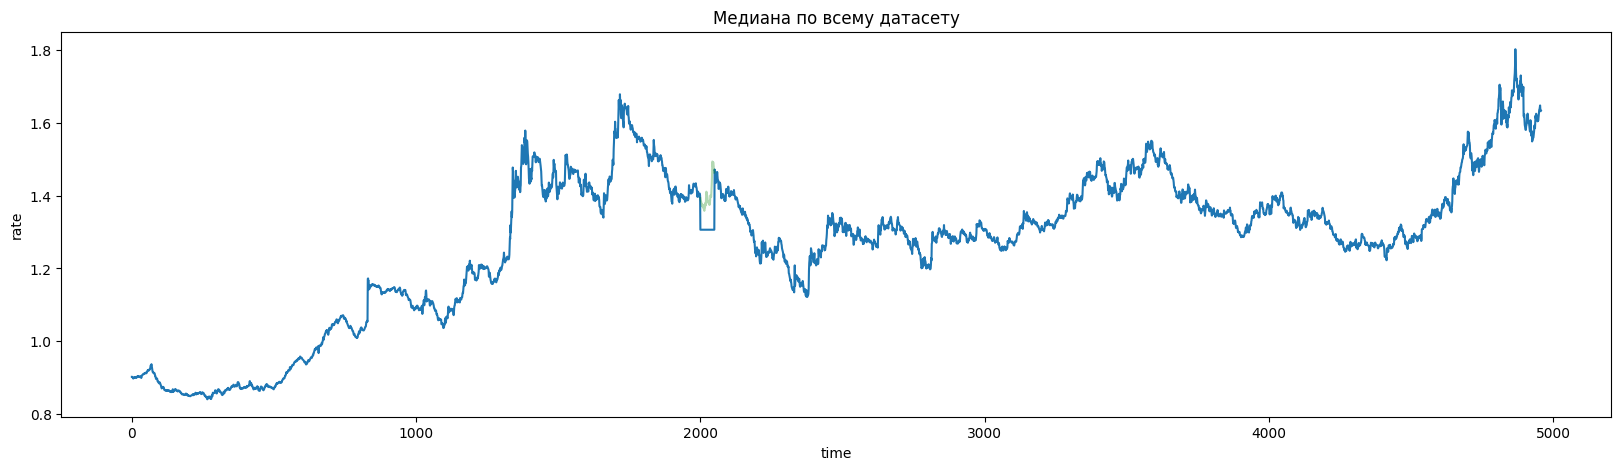

In [77]:
restored = missing_values.copy()
restored[2000:2050] = np.median(missing_values.dropna())
plot_assignation(restored, 'Медиана по всему датасету', 'time', 'rate')
plt.plot(ts[2000:2050], color='g', alpha=0.3)
plt.show()

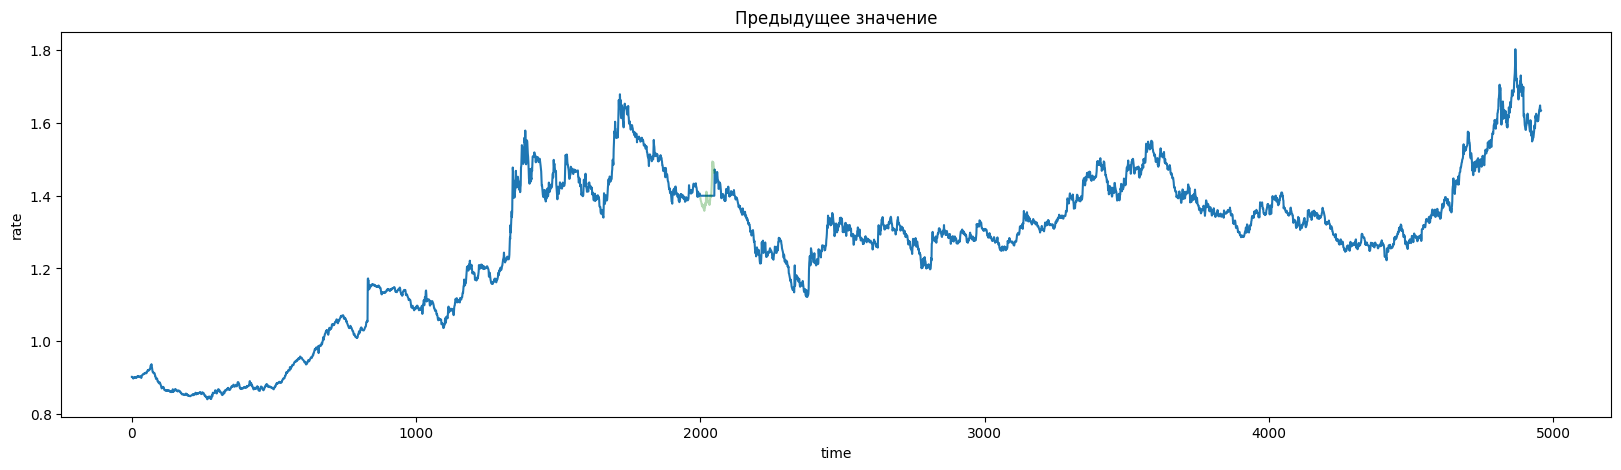

In [79]:
restored = missing_values.copy()
restored[2000:2050] = missing_values[1999]
plot_assignation(restored, 'Предыдущее значение', 'time', 'rate')
plt.plot(ts[2000:2050], color='g', alpha=0.3)
plt.show()

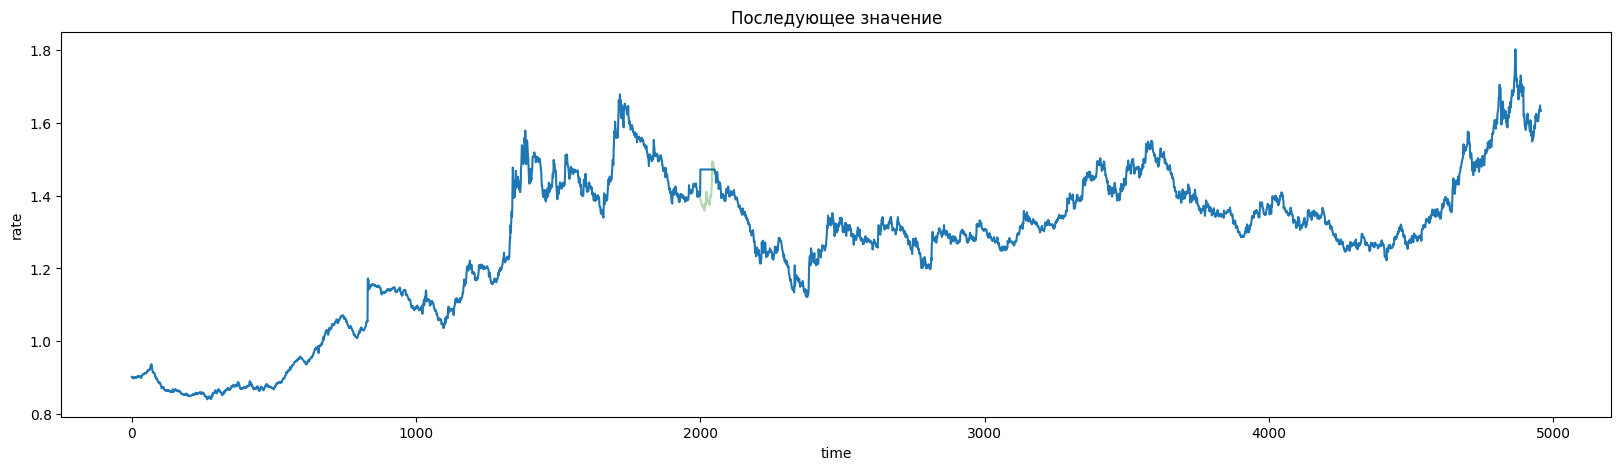

In [80]:
restored = missing_values.copy()
restored[2000:2050] = missing_values[2050]
plot_assignation(restored, 'Последующее значение', 'time', 'rate')
plt.plot(ts[2000:2050], color='g', alpha=0.3)
plt.show()

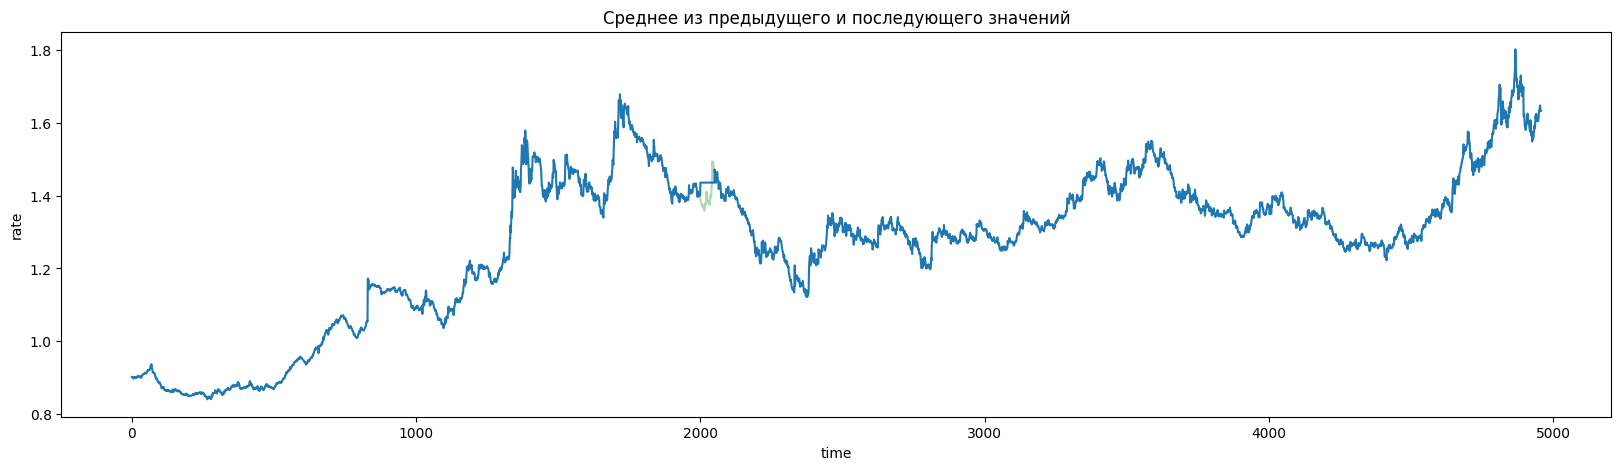

In [81]:
restored = missing_values.copy()
restored[2000:2050] = (missing_values[1999] + missing_values[2050]) / 2
plot_assignation(
    restored,
    'Среднее из предыдущего и последующего значений',
    'time',
    'rate')
plt.plot(ts[2000:2050], color='g', alpha=0.3)
plt.show()

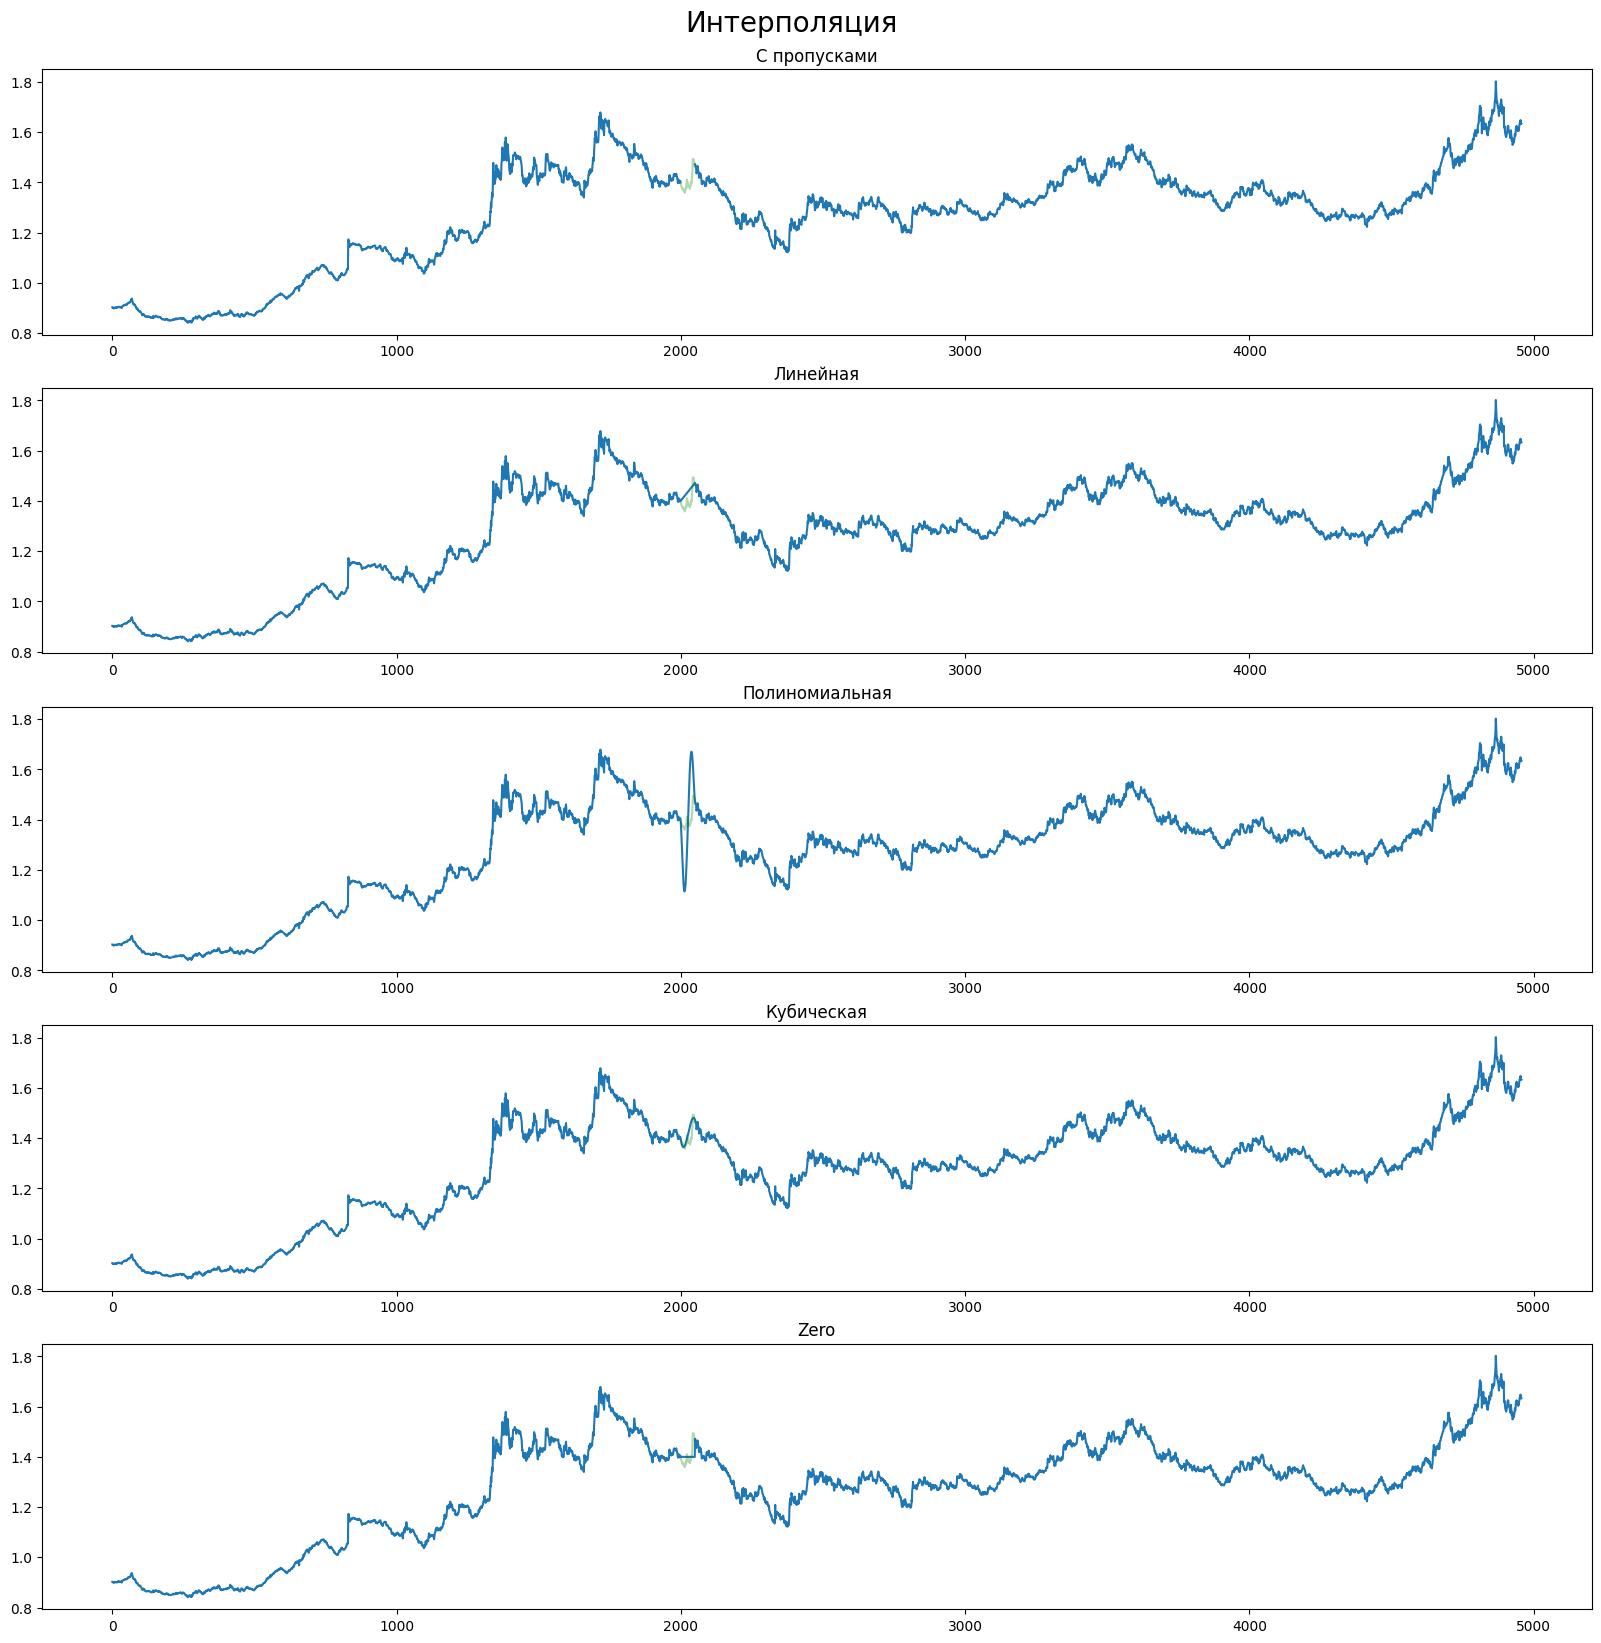

In [ ]:
interpolations = {
    'С пропусками': missing_values,
    'Линейная': missing_values.interpolate(method='linear'),
    'Полиномиальная': missing_values.interpolate(method='polynomial', order=5),
    'Кубическая': missing_values.interpolate(method='cubic'),
    'Zero': missing_values.interpolate(method='zero'),
}

fig, ax = plt.subplots(5, 1, figsize=(20, 20))
fig.suptitle('Интерполяция', y=0.91, fontsize=20)

for i, key in enumerate(interpolations.keys()):
    ax[i].plot(interpolations[key])
    ax[i].set_title(key)
    ax[i].plot(ts[2000:2050], color='g', alpha=0.3)

### Работа с выбросами

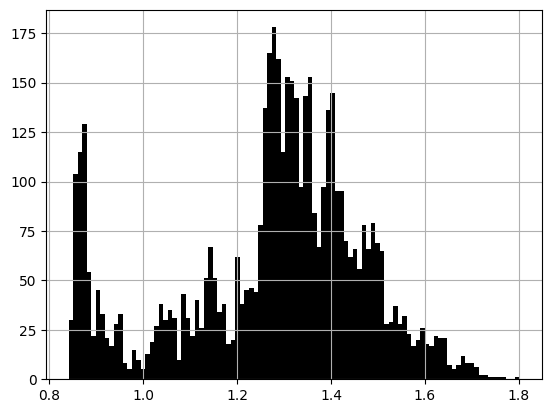

In [114]:
ts.hist(bins=100, color='black')
plt.show()

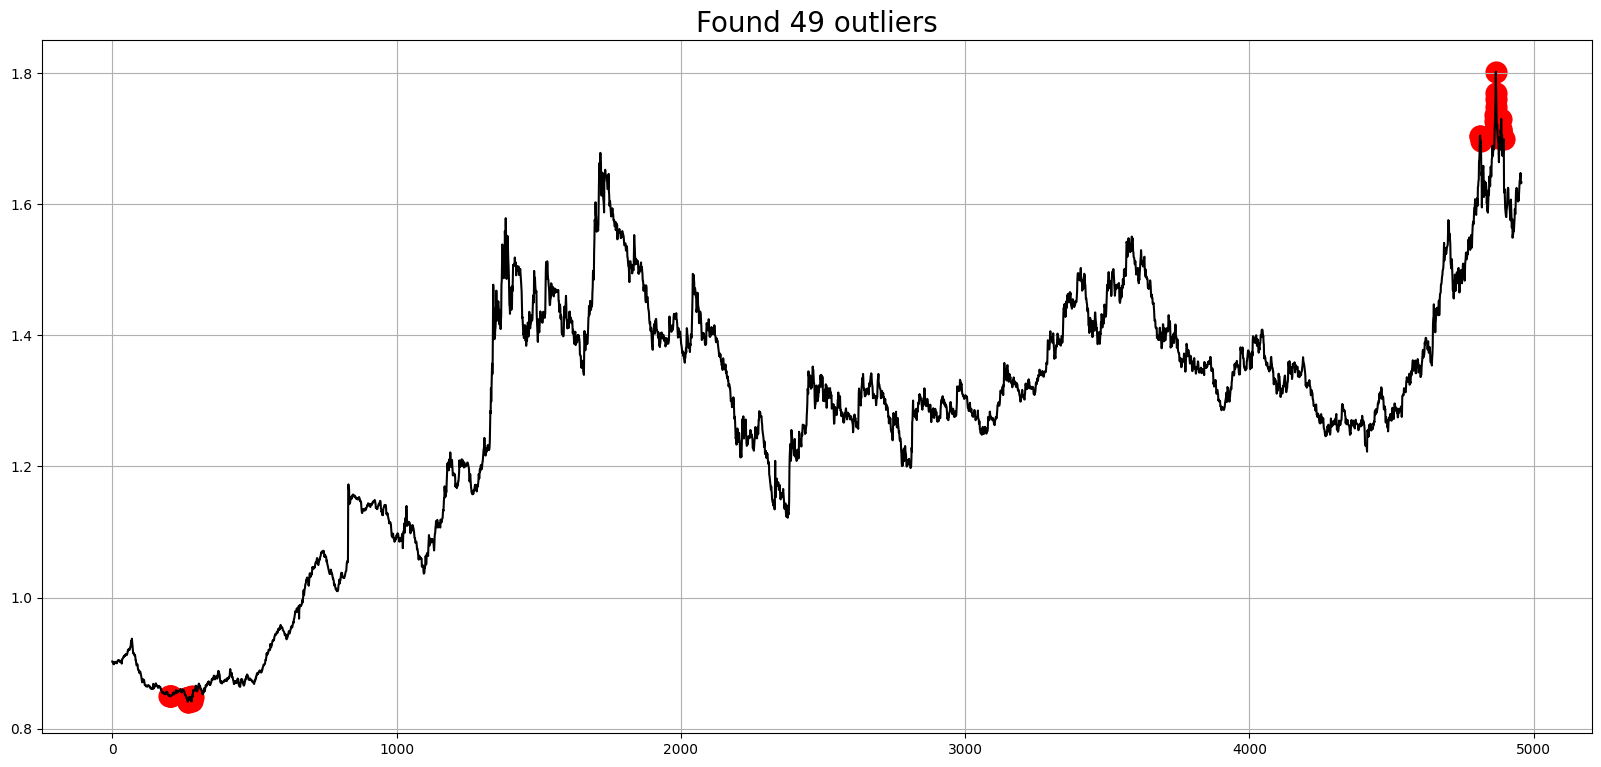

In [123]:
# ищем выбросы

scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = pd.Series(ts)

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1, 1))
model = svm.OneClassSVM(nu=perc, kernel='rbf', gamma=0.01)
model.fit(ts_scaled)
dtf_outliers = local_df.to_frame(name='ts')
dtf_outliers['index'] = range(len(local_df))
dtf_outliers['outlier'] = model.predict(ts_scaled)
dtf_outliers['outlier'] = dtf_outliers['outlier'].apply(lambda
                                                        x: 1 if x == -1 else 0)
# plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers['index'], dtf_outliers['ts'],
        color='black')
ax.scatter(x=dtf_outliers[dtf_outliers['outlier'] == 1]['index'],
           y=dtf_outliers[dtf_outliers['outlier'] == 1]['ts'],
           color='red', linewidths=10)
plt.title(
    f"Found {sum(dtf_outliers['outlier']==1)} outliers",
    fontdict={
        'fontsize': 20})
ax.grid(True)
plt.show()

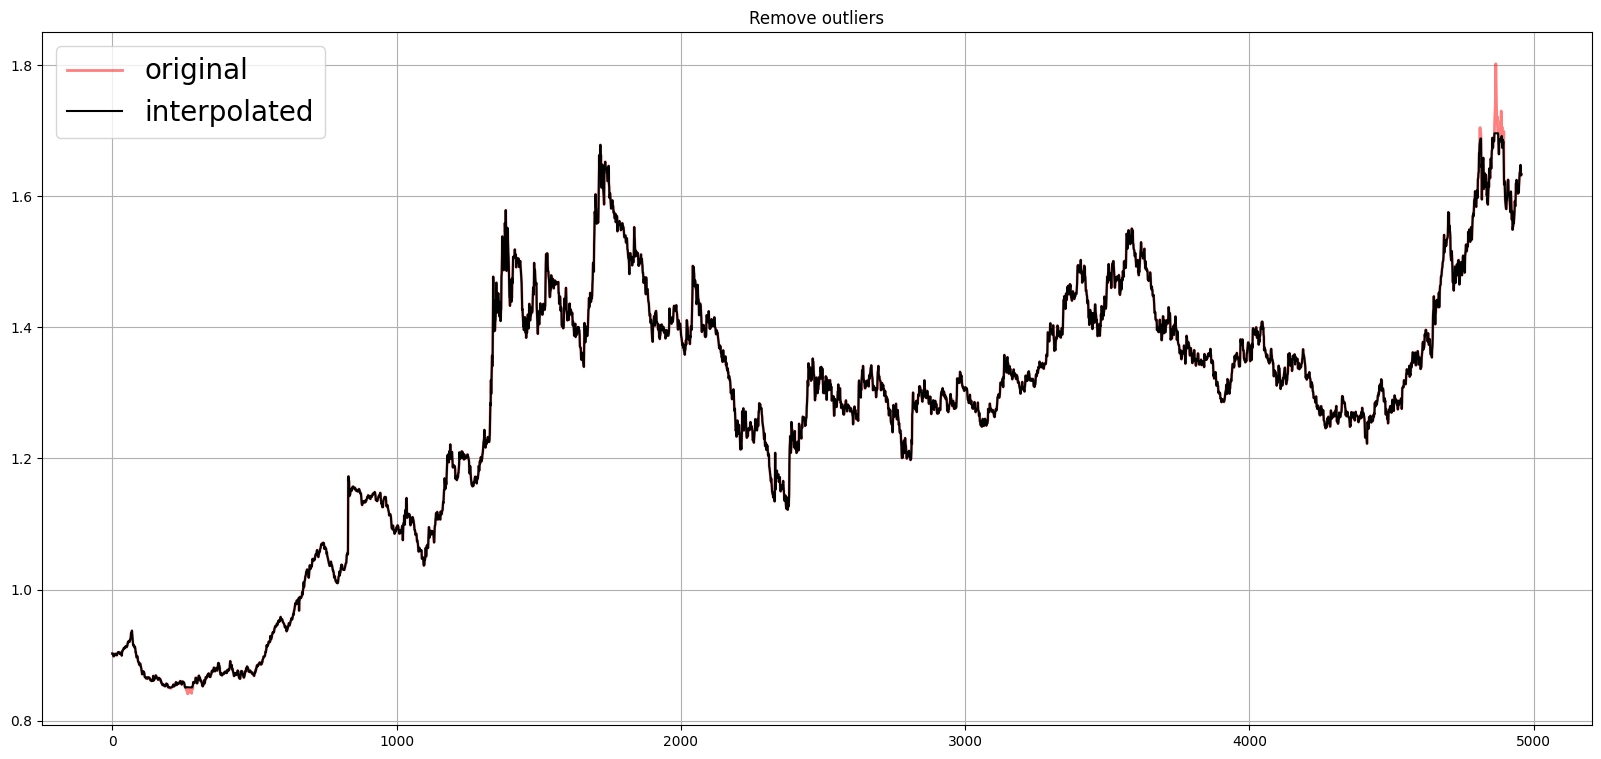

In [119]:
outliers_idx = dtf_outliers[dtf_outliers['outlier'] == 1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method='linear')
ax = local_df.plot(figsize=(20, 9), color='red', alpha=0.5,
                   title='Remove outliers', label='original', legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color='black',
              label='interpolated', legend=True)
plt.legend(fontsize='20')
plt.show()